## ２章のkeras版
Deep Reinforcement Learning in Actionの２章にでてくる「多椀バンディット問題(Multi-Arm Bandit)」をTorchではなく、Kerasを使って試してみました。

多椀バンディット問題は、強化学習では有名な例題みたいです。
- http://ibisml.org/archive/ibis2014/ibis2014_bandit.pdf

前提条件
- 複数台のスロットマシンをプレイするギャンブラーのモデル 
- 得られる報酬の確率分布は台によって異なる
- なるべく期待値の高い台をプレイしたい

問題点
- ある程度の回数プレイしないと台の良し悪しが分からない
- 報酬の期待値の低い台を何度もプレイすると損

ここでは、最高$10まででる１０台のスロットルマシーンが題材となっている。

- 報酬: $R_k$（k回目の報酬）
- 報酬の期待値: $Q_k(a)$（アクションaに対するk回目までの期待値）

$$
Q_k(a) = \frac{R_1 + R_2 + ... + R_k}{k_a}
$$

アクションaの最尤値は、以下のように定義される。

$$
a = argmax_a (Q_k(a))
$$

### 前準備
最初に必要なライブラリーをインポートしておきます。

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
from IPython.display import Image
%matplotlib inline

# keras用のパッケージをインポート
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


## 環境のセット
多椀バンディットのクラスとしてContextBanditを使用します（サポートページからの引用）。


In [2]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward


## モデル作成
ニューラルネットで使用するモデルは、入力１０、隠れ層100、出力10のモデルです。
- 入力：アクションを10個の配列で表現
- 出力: 報酬の予測値

処理の流れを図で表すために、Dot記述でグラフを描いてみました（dot記法の練習）。

In [3]:
%%writefile models/ex_5a.dot
digraph ex_5 {
    graph [rankdir=LR, charset="UTF-8"];
    // グラフ名はcluster_で始める
    // node
    env_get_state [label="env.get_state()", shape="box", style="rounded,filled"];
    one_hot_encode [label="One-Hot\nEncode", shape="box", style="rounded,filled"];
        
    subgraph cluster_1 {
        label = "Layer1";
        style= "rounded";
        
        theta1 [label="θ_1:10x100", shape="box", style="rounded,filled"];
        ReLU1 [label="ReLU", shape="box", style="rounded,filled"];
        
        theta1 -> ReLU1 [arrowhead=none];
    };

    env_get_state -> one_hot_encode [label="整数", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];
    one_hot_encode -> theta1 [label="実数[10]", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];

    sample_action [label="Sample Action", shape="box", style="rounded,filled"];
    softmax [label="Softmax", shape="box", style="rounded,filled"];

    subgraph cluster_2 {
        label = "Layer2";
        style= "rounded";
        
        ReLU2 [label="ReLU", shape="box", style="rounded,filled"];
        theta2 [label="θ_2:100x10", shape="box", style="rounded,filled"];
        
        ReLU2 -> theta2  [arrowhead=none];        
    };
    
    ReLU1 -> theta2  [arrowhead=none, topath="bend left"]; 
    
    sample_action -> softmax [label="確率[10]", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];
    softmax -> ReLU2  [label="実数[10]", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];
    
    // node
    env_choose_arm [label="env.choose_arm()", shape="box", style="rounded,filled"];
    loss_function [label="Loss Function", shape="box", style="rounded,filled"];
    Optimizer [shape="box", style="rounded,filled"];
    
    env_choose_arm -> loss_function [label="報酬:整数", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];
    loss_function -> Optimizer [arrowhead=none];
    
    sample_action -> env_choose_arm [label="整数", fontname="ipafont-gothic", lblstyle="auto", arrowhead=none];

    newrank=true;
    {rank=same; ReLU1, theta2}
    {rank=same; env_get_state, sample_action, env_choose_arm}
    {rank=same; one_hot_encode, softmax, loss_function}
}

Overwriting models/ex_5a.dot


In [4]:
%%bash
dot -Tpng -Gdpi=200 models/ex_5a.dot> images/ex_5a.png

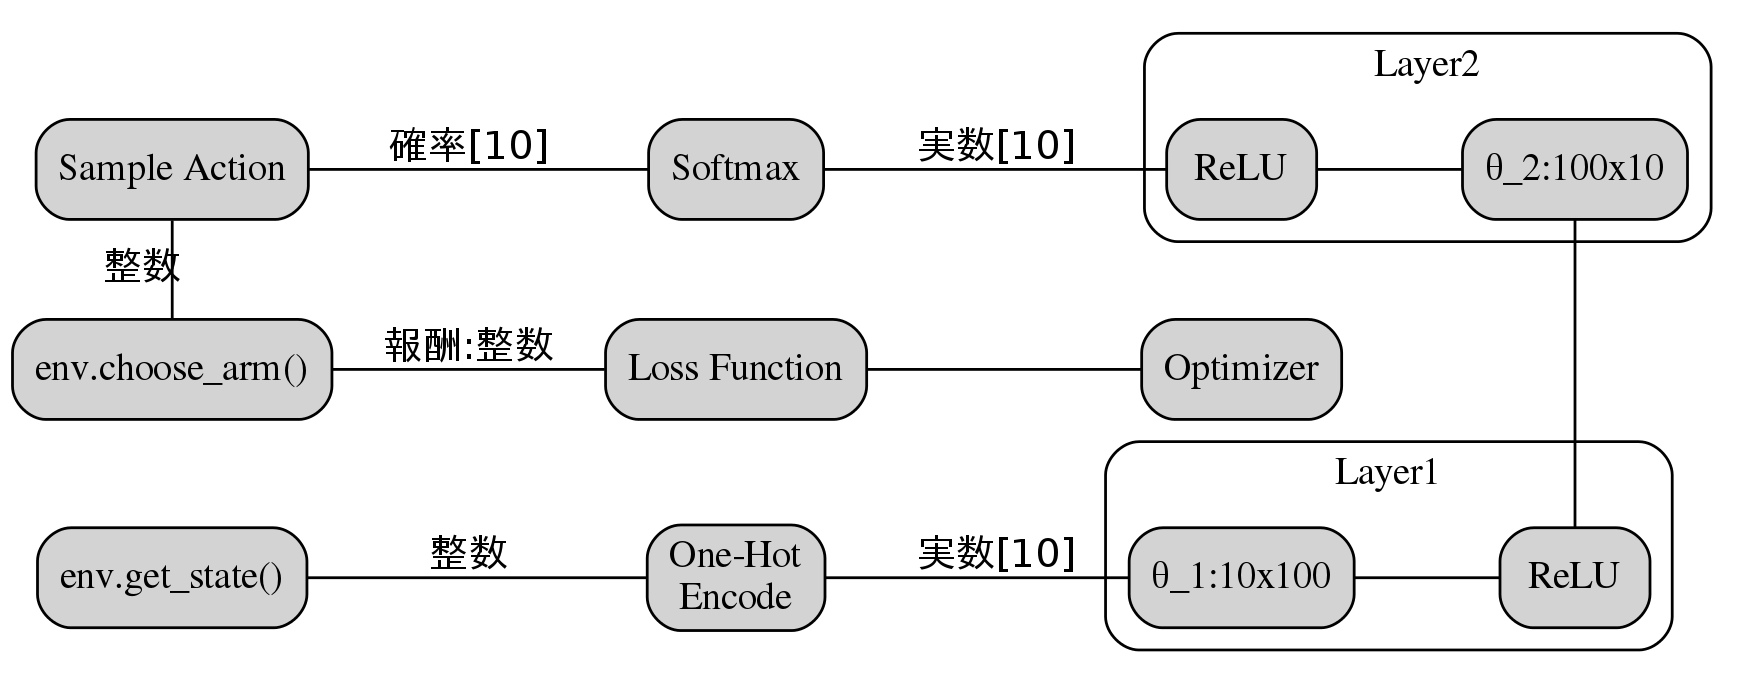

In [5]:
Image("images/ex_5a.png")

処理の流れは、以下のようになります。
- env.get_stateで環境から状態を取得し、One-Hot形式に変換
- ニューラルネットワークの１層の入力とし、隠れ層100で活性関数としてReLU
- ニューラルネットワークの２層目は出力で、10のスロットルの予測値を得る
- Softmaxで確率分布に変換
- 確率からアクションをサンプリングする
- 環境からスロットルを実行し、報酬を得る
- ニューラルネットワークの更新

In [7]:
def softmax(av, tau=1.12):
    n = len(av)
    probs = np.zeros(n)
    for i in range(n):
        softm = ( np.exp(av[i] / tau) / np.sum( np.exp(av[:] / tau) ) )
        probs[i] = softm
    return probs

def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

arms = 10
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 1, arms, 100, arms

model = Sequential()
model.add(Dense(H, activation='relu', input_dim=D_in))
model.add(Dense(D_out, activation='relu'))

learning_rate = 1e-2
optimizer = optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['accuracy'])

In [8]:
env = ContextBandit(arms)

In [9]:
def train(env):
    epochs = 5000
    #one-hot encode current state
    cur_state = one_hot(arms,env.get_state()).reshape(1, D_in)
    reward_hist = np.zeros(50)
    reward_hist[:] = 5
    runningMean = np.average(reward_hist)
    plt.xlabel("Plays")
    plt.ylabel("Mean Reward")
    for i in range(epochs):
        cur_state = one_hot(arms,env.get_state())[np.newaxis,:]
        y_pred = model.predict(cur_state) #produce reward predictions
        av_softmax = softmax(y_pred.flatten(), tau=2.0) #turn reward distribution into probability distribution
        av_softmax /= av_softmax.sum() #make sure total prob adds to 1
        choice = np.random.choice(arms, p=av_softmax) #sample an action
        cur_reward = env.choose_arm(choice)
        one_hot_reward = y_pred.copy()[0]
        one_hot_reward[choice] = cur_reward
        one_hot_reward = one_hot_reward[np.newaxis,:]
        
        if i % 50 == 0:
            runningMean = np.average(reward_hist)
            reward_hist[:] = 0
            plt.scatter(i, runningMean)
        reward_hist[i % 50] = cur_reward
        
        model.fit(cur_state, one_hot_reward, epochs=1, batch_size=1, verbose=0)

        cur_state = one_hot(arms,env.get_state())[np.newaxis,:]

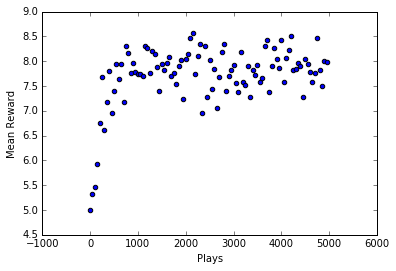

In [10]:
train(env)